In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict

#Imported libraries// Now importing test and train data

In [34]:
test_lines = []
test_cat = []
for line in open('test_set.txt'):
    split_line = line.split(" ", 1)
    test_cat.append(split_line[0].split(":")[0])
    test_lines.append(split_line[1][:-1])

In [35]:
len(test_lines)

500

In [36]:
lines = []
categories = []
for line in open('5500_set.txt'):
    split_line = line.split(" ", 1)
    categories.append(split_line[0].split(":")[0])
    lines.append(split_line[1][:-1])
print(np.unique(categories))

['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']


In [37]:
total_lines = lines 

Creating a Tokenizer and a dictionary builder

In [38]:
def tokenizing(caption):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(caption.lower())
    tokens_new = []
    for t in tokens:
        t = t.encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0:
            tokens_new.append(t)
    return tokens_new
def build_dictionary(train_captions):
    word_counts = defaultdict(float)
    for sent in train_captions:
        for word in sent:
            word_counts[word] += 1
    vocab = [w for w in word_counts if word_counts[w] >= 0]

    ixtoword = {}
    ixtoword[0] = '<end>'
    wordtoix = {}
    wordtoix['<end>'] = 0
    ix = 1
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1

    train_captions_new = []
    for t in train_captions:
        rev = []
        for w in t:
            if w in wordtoix:
                rev.append(wordtoix[w])
        # rev.append(0)  # do not need '<end>' token
        train_captions_new.append(rev)
    print(len(ixtoword))
    return train_captions_new,ixtoword, wordtoix, len(ixtoword)

In [39]:
lines_transformed = [tokenizing(question) for question in total_lines]

Total number of words in the dictionary

In [40]:
lines_transformed_2, ixtoword, wordtoix, vocab = build_dictionary(lines_transformed)

8448


In [41]:
lines_transformed_2[:5]

[[1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16],
 [1, 17, 18, 19, 20, 21, 22, 23, 24, 25],
 [10, 26, 27, 13, 28, 29, 13, 30, 31, 22, 13, 32],
 [10, 33, 13, 34, 35, 22, 36]]

In [42]:
max([len(line) for line in lines_transformed_2])

33

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
X_dash = pad_sequences(lines_transformed_2,maxlen=33)

In [48]:
X_train = X_dash

In [49]:
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [50]:
len(X_train)

5452

In [51]:
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding

Categories to one hot vectors

In [52]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [53]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories)
print(integer_encoded)

[1 2 1 ... 5 5 2]


In [54]:
from tensorflow.keras.utils import to_categorical
encoded = to_categorical(integer_encoded)

In [55]:
encoded.shape

(5452, 6)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

Writing the small model for semantic understanding and training it with early stopping(based on validation loss)

In [61]:
model = Sequential()
model.add(Embedding(8448, 40, input_length=X_dash.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(35, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 40
batch_size = 20
history = model.fit(X_train, encoded, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/40
219/219 - 8s - loss: 1.5701 - accuracy: 0.3330 - val_loss: 1.1563 - val_accuracy: 0.5683
Epoch 2/40
219/219 - 8s - loss: 0.8761 - accuracy: 0.6939 - val_loss: 0.7604 - val_accuracy: 0.7489
Epoch 3/40
219/219 - 8s - loss: 0.4265 - accuracy: 0.8716 - val_loss: 0.6264 - val_accuracy: 0.7910
Epoch 4/40
219/219 - 8s - loss: 0.2476 - accuracy: 0.9296 - val_loss: 0.6182 - val_accuracy: 0.8139
Epoch 5/40
219/219 - 8s - loss: 0.1363 - accuracy: 0.9617 - val_loss: 0.6077 - val_accuracy: 0.8167
Epoch 6/40
219/219 - 8s - loss: 0.0918 - accuracy: 0.9759 - val_loss: 0.5994 - val_accuracy: 0.8341
Epoch 7/40
219/219 - 8s - loss: 0.0581 - accuracy: 0.9856 - val_loss: 0.6127 - val_accuracy: 0.8387
Epoch 8/40
219/219 - 8s - loss: 0.0510 - accuracy: 0.9872 - val_loss: 0.6720 - val_accuracy: 0.8286
Epoch 9/40
219/219 - 8s - loss: 0.0357 - accuracy: 0.9931 - val_loss: 0.7101 - val_accuracy: 0.8176


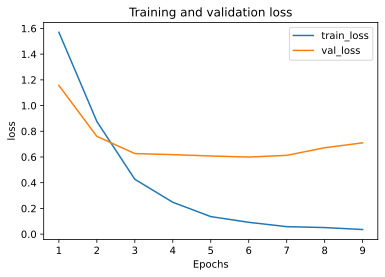

In [62]:
import matplotlib.pyplot as plt
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history,'loss')

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.show()

In [26]:
history

In [27]:
history.history['accuracy']

[0.33065810799598694,
 0.697087824344635,
 0.8663150668144226,
 0.9261637330055237,
 0.9580371379852295,
 0.9766108393669128,
 0.9832606911659241]

Saving the model

In [64]:
model.save('classifier.pth')

In [65]:
import tensorflow.keras.models as ms
loda = ms.load_model('classifier.pth')

In [31]:
print(loda.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f24acd3e9d0>>


Encoding the test vector with the dictionary created from train. If word not in the dictionary, put 0

In [56]:
def int_encoding(word_dict,sents):
    new_sents = []
    for sent in sents:
        vector = []
        sent = tokenizing(sent)
        for token in sent:
            if token in word_dict:
                vector.append(word_dict[token])
            else:
                vector.append(0)
        new_sents.append(vector)
    return new_sents

In [57]:
test_tokens = int_encoding(wordtoix,test_lines)

In [58]:
test_tokens

[[1, 2113, 33, 287, 41, 7037, 96, 0],
 [10, 742, 33, 0, 1025, 5],
 [75, 64, 0],
 [10, 33, 111, 3673],
 [63, 2, 5295, 50, 20, 89],
 [1, 3899, 33, 13, 0, 2000],
 [909, 2668, 7311, 20, 367, 0, 5, 143, 45, 44],
 [10, 33, 2067, 46, 410, 3071],
 [68, 148, 13, 662, 1082, 3040],
 [10, 33, 0],
 [10, 295, 640, 20, 211, 7972, 5, 0],
 [10, 1506, 46, 359, 33, 250, 20, 5004],
 [10, 33, 13, 1486, 993, 22, 20, 1324, 0],
 [75, 64, 13, 208, 178, 96, 2905, 4274, 13, 1588, 1126],
 [63, 2, 0, 50, 20, 89],
 [10, 33, 13, 1651, 4144, 152, 0],
 [10, 1516, 85, 13, 135, 0, 399],
 [75, 3444, 13, 0, 862, 3445],
 [10, 33, 0],
 [10, 31, 2, 13, 835, 1122],
 [75, 64, 13, 208, 600, 96, 4378, 5, 601],
 [10, 33, 20, 0],
 [10, 311, 5, 13, 1092, 33, 194, 195, 13, 1157, 0],
 [10, 33, 0, 0],
 [10, 33, 0],
 [75, 3444, 13, 0, 717],
 [10, 33, 2699],
 [10, 3762, 615, 33, 0, 1312, 13, 655, 6, 602, 0],
 [184, 33, 235, 6419, 1373],
 [10, 731, 33, 13, 3217, 5],
 [10, 33, 13, 1486, 1212, 22, 13, 2222, 342, 13, 1701, 6311],
 [184, 53,

In [59]:
X_test = pad_sequences(test_tokens,maxlen=33)
y_test = to_categorical(label_encoder.transform(test_cat))

Evaluate the model on Test data

In [66]:
loda.evaluate(X_test, y_test, batch_size=50)

10/10 [==============================] - 0s 7ms/step - loss: 0.4303 - accuracy: 0.8720


[0.43027129769325256, 0.871999979019165]